In [1]:
import os
root_dir = '/home/tim/Dropbox/experimental/' # your path here where to parent directory where repos are
os.chdir(root_dir)
from map_data.map_methods import *
from supervised_learning.supervised_methods import *
from utils.global_methods import *

cpu count: 20
gpu count: 2
cuda avail: True


In [4]:
# load model directories to read later
model_dirs = []
model_paramss = []
for scale in [1/32, 1/16, 1/10, 1/8, 1/6, 1/4, 1/2, 1, 2, 4, 6, 8, 10]:
    for random_seed in range(10):
        scale_str = str(round(scale, 4)).replace('.', 'd')
        model_dir = f'models/archive/monocular_depth/DGNLNet/AirSimNH_v3/scale_{scale_str}/seed_{random_seed}/'
        if not os.path.exists(model_dir+'eval_metrics.json'):
            continue
        model_dirs.append(model_dir)
        model_paramss.append({
            'scale':scale,
            'random_seed':random_seed,
        })
print(len(model_dirs), 'models to read')

125 models to read


In [5]:
# read error metrics
r2s = []
mapes = []
scales = []
random_seeds = []
r2_by_scale = {}
mape_by_scale = {}
for i in range(len(model_dirs)):
    model_dir = model_dirs[i]
    model_params = model_paramss[i]
    eval_metrics = read_json(model_dir+'eval_metrics.json')
    r2 = eval_metrics['r2_test']
    mape = eval_metrics['mape_test']
    scale = model_params['scale']
    random_seed = model_params['random_seed']
    r2s.append(r2)
    scales.append(scale)
    random_seeds.append(random_seed)
    mapes.append(mape)
    if scale not in r2_by_scale:
        r2_by_scale[scale] = []
        mape_by_scale[scale] = []
    r2_by_scale[scale].append(r2)
    mape_by_scale[scale].append(mape)

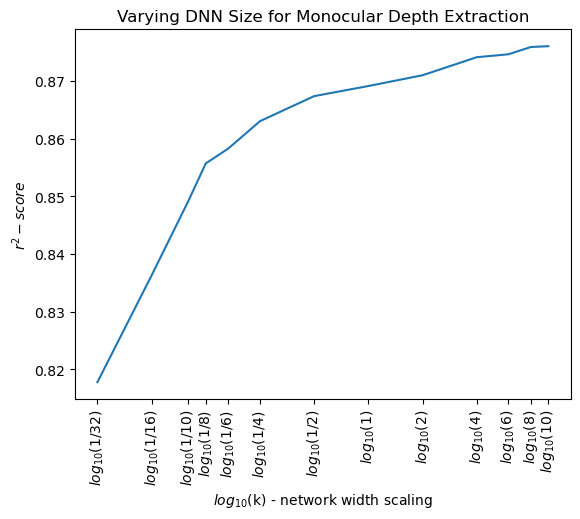

In [18]:
best_r2s = []
best_r2s_dict = {}
best_seeds = []
scales = []
scale_strs = []
for scale in r2_by_scale:
    _r2s = r2_by_scale[scale]
    best_r2 = _r2s[0]
    best_seed = 0
    for seed, r2 in enumerate(_r2s):
        if r2 > best_r2:
            best_r2 = r2
            best_seed = seed
    scales.append(scale)
    best_r2s.append(best_r2)
    best_r2s_dict[scale] = best_r2
    best_seeds.append(best_seed)
    scale_str = str(round(scale, 4)).replace('.', 'd')
    scale_strs.append(scale_str)
tf = np.log10
plt.plot([tf(scale) for scale in scales], best_r2s)
plt.xticks([tf(1/32), tf(1/16), tf(1/10), tf(1/8), tf(1/6), tf(1/4), tf(1/2), tf(1), 
           tf(2), tf(4), tf(6), tf(8), tf(10)], 
          [r'$log_{10}(1/32)$', r'$log_{10}(1/16)$', r'$log_{10}(1/10)$',
          r'$log_{10}(1/8)$', r'$log_{10}(1/6)$', r'$log_{10}(1/4)$', r'$log_{10}(1/2)$',
          r'$log_{10}(1)$', r'$log_{10}(2)$', r'$log_{10}(4)$', r'$log_{10}(6)$',
          r'$log_{10}(8)$', r'$log_{10}(10)$',], rotation=90)
plt.xlabel(r'$log_{10}$(k) - network width scaling')
plt.ylabel(r'$r^2-score$')
plt.title('Varying DNN Size for Monocular Depth Extraction')
plt.show()

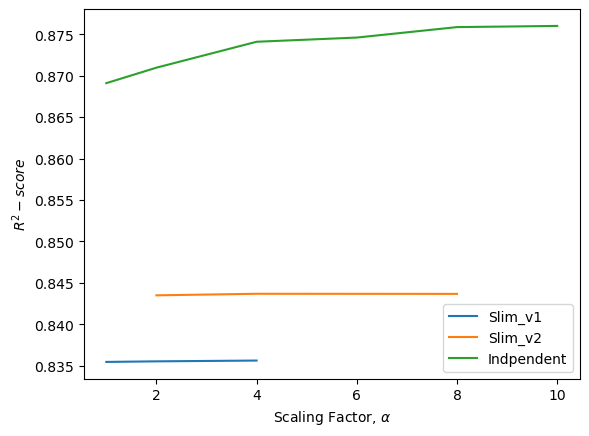

In [19]:
# load model directories to read later
slim_dirs = [
    f'models/archive/monocular_depth/DGNLNet/AirSimNH_v7/poc/',
    f'models/archive/monocular_depth/DGNLNet/AirSimNH_v8/poc/',
]
labels = [
    'Slim_v1',
    'Slim_v2',
]
min_scale = 777
max_scale = -777
slim_results = []
for i, slim_dir in enumerate(slim_dirs):
    rhos = pk_read(f'{slim_dir}rhos.p')
    r2s = pk_read(f'{slim_dir}r2s.p')
    scale = pk_read(f'{slim_dir}scale.p')
    min_scale = min(scale, min_scale)
    max_scale = min(scale, max_scale)
    xs = []
    ys = []
    for rho_idx in range(len(rhos)):
        rho = rhos[rho_idx]
        x = scale*rho
        #for eval_set in r2s:
        #    r2 = r2s[eval_set][rho_idx]
        r2 = r2s['test'][rho_idx]
        y = r2
        xs.append(x)
        ys.append(y)
    slim_results.append([xs, ys, labels[i]])

for slim_result in slim_results:
    plt.plot(slim_result[0], slim_result[1], label=slim_result[2])
    
plt.plot([scale for scale in scales if scale >= 1], [best_r2s_dict[scale] for scale in scales if scale >= 1], label='Indpendent')
plt.legend()
plt.ylabel(r'$R^2-score$')
plt.xlabel(r'Scaling Factor, $\alpha$')
plt.show()

In [15]:
slim_results

[[[1.0, 2.0, 4.0],
  [0.8354461016672987, 0.8355157637557139, 0.8356106482027167],
  'Slim_v1'],
 [[2.0, 4.0, 8.0],
  [0.8434834850658741, 0.8436725862355594, 0.8436595163772327],
  'Slim_v2']]

In [20]:
best_r2s_dict

{0.03125: 0.8177550435066223,
 0.0625: 0.8362678289413452,
 0.1: 0.8491673469543457,
 0.125: 0.8556817770004272,
 0.16666666666666666: 0.8582542538642883,
 0.25: 0.8630011081695557,
 0.5: 0.8673469424247742,
 1: 0.869095504283905,
 2: 0.8709644079208374,
 4: 0.8740928173065186,
 6: 0.8745997548103333,
 8: 0.8758612275123596,
 10: 0.8760042627769213}

In [19]:
pk_read(f'{slim_dir}scale.p')

2.4

In [25]:
best_seeds

[9, 8, 4, 8, 9, 2, 5, 1, 3, 6, 8, 3, 2]

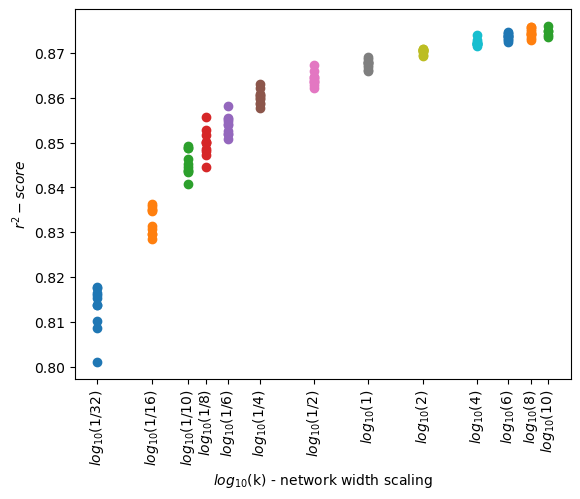

In [14]:
tf = np.log10
for scale in r2_by_scale:
    bin = r2_by_scale[scale]
    plt.scatter([tf(scale) for _ in range(len(bin))], bin)
plt.xlabel(r'$log_{10}$(k) - network width scaling')
plt.xticks([tf(1/32), tf(1/16), tf(1/10), tf(1/8), tf(1/6), tf(1/4), tf(1/2), tf(1), 
           tf(2), tf(4), tf(6), tf(8), tf(10)], 
          [r'$log_{10}(1/32)$', r'$log_{10}(1/16)$', r'$log_{10}(1/10)$',
          r'$log_{10}(1/8)$', r'$log_{10}(1/6)$', r'$log_{10}(1/4)$', r'$log_{10}(1/2)$',
          r'$log_{10}(1)$', r'$log_{10}(2)$', r'$log_{10}(4)$', r'$log_{10}(6)$',
          r'$log_{10}(8)$', r'$log_{10}(10)$',], rotation=90)
plt.ylabel(r'$r^2-score$')
plt.show()

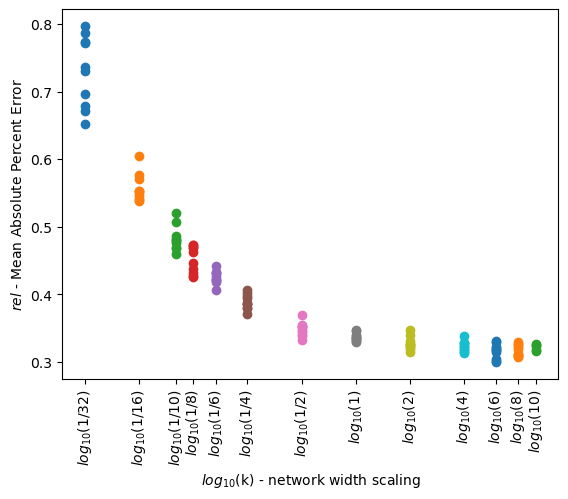

In [10]:
for scale in mape_by_scale:
    bin = mape_by_scale[scale]
    plt.scatter([np.log10(scale) for _ in range(len(bin))], bin)
plt.xlabel(r'$log_{10}$(k) - network width scaling')
plt.xticks([tf(1/32), tf(1/16), tf(1/10), tf(1/8), tf(1/6), tf(1/4), tf(1/2), tf(1), 
           tf(2), tf(4), tf(6), tf(8), tf(10)], 
          [r'$log_{10}(1/32)$', r'$log_{10}(1/16)$', r'$log_{10}(1/10)$',
          r'$log_{10}(1/8)$', r'$log_{10}(1/6)$', r'$log_{10}(1/4)$', r'$log_{10}(1/2)$',
          r'$log_{10}(1)$', r'$log_{10}(2)$', r'$log_{10}(4)$', r'$log_{10}(6)$',
          r'$log_{10}(8)$', r'$log_{10}(10)$',], rotation=90)
plt.ylabel(r'$rel$ - Mean Absolute Percent Error')
plt.show()